# Countries Explorative Data Analysis (EDA)

In [3]:
from bs4 import BeautifulSoup
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import time

## Overview
The dataset used in this project contains information about all the countries in the world. The objective of the analysis is to gain insights about population, area, languages spoken, distribution of wealth, life expectancy and death rate.

## Questions for Analysis

1. What are the 10 most populated countries?
2. What are the top 3 least populated countries by continent?
3. What is the least populated continent?
4. What are the top 20 largest countries?
5. What is the smallest continent?
6. What are the top 5 most common languages?
7. - What are the 10 countries with the most inequalities?
   - What are the 10 countries with the least inequalities?
8. - What is the continent with the highest death rate?
   - What is the continent with the lowest death rate?
9. - What is the overall average life expectancy?
   - What is the average life expectancy by continent?
10. What variable seems to be correlated to life expectancy the most?

## About Dataset

The dataset comes from 4 different sources
- [REST Countries API](https://restcountries.com/)
- [World Bank Group](https://datacatalog.worldbank.org/search/dataset/0038130) (dowloaded CSV)
- [Worldometer](https://www.worldometers.info/demographics/life-expectancy/) (web scraping)
- [CIA](https://www.cia.gov/the-world-factbook/field/death-rate/country-comparison/) (downloaded CSV)

### Columns description
- ```name```: country name
- ```code```: ISO 3166 country code
- ```continent```: continent of the country
- ```population```: population of the country
- ```area```: country area, in square kilometers
- ```languages```: languages spoken
- ```gdp```: Gross Domestic Product (GDP), in millions of US Dollars
- ```gdp_per_capita```: Gross Domestic Product per 100,000 people
- ```gini```: GINI Coefficient or GINI Index. It measures inequality on a scale from 0 to 100, 0 being perfect equality and 100 being perfect inequality.
- ```death_rate```: death rate per 1000 people (2024 estimate)
- ```life_expentancy```: life expentancy for both sexes

## Step 1 - Data Collection

### Create countries CSV file from API

In [9]:
# Handle ChunkedEncodingError by adding 'try except' and adding 1 second pause between each attempt
for attempt in range(5):
    country_list = []
    
    try:
        response = requests.get('https://restcountries.com/v3.1/all')
        
        if response.status_code != 200:
            print('Failed to find data')

        else:
            countriesJson = json.loads(response.content)
    
            # Collect relevant columns
            for item in countriesJson:
                keys = item.keys()
                country = {
                    'name': item['name']['common'],
                    'cca3': item['cca3'],
                    'continent' : item['continents'][0],
                    'population': item['population'],
                    'area': item['area'],
                    'languages': ', '.join(list(item['languages'].values())) if 'languages' in keys else None,
                    'gini': list(item['gini'].values())[0] if 'gini' in keys else None
                }
                country_list.append(country)
    
            header = country_list[0].keys()
    
            ## Create/replace CSV file
            with open('Data/countries.csv', 'w', newline='') as output_file:
                dict_writer = csv.DictWriter(output_file, header)
                dict_writer.writeheader()
                dict_writer.writerows(country_list)
                output_file.close()
                print('CSV file', output_file.name, 'created successfully')
    
        break
    except requests.exceptions.ChunkedEncodingError:
        time.sleep(1)
else:
    print('Failed to fetch data from REST countries API')

CSV file Data/countries.csv created successfully


### Create life expectancy CSV through web scraping

In [11]:
# Scrape the table
response = requests.get('https://www.worldometers.info/demographics/life-expectancy/')

if response.status_code != 200:
    print('Failed to fetch data.')
else:
    soup = BeautifulSoup(response.content)
    life_exp_table = soup.find('table', {'id': 'example2'})
    
    # save the data into a dictionary
    life_exp_list = []
    
    # header
    table_header = life_exp_table.select('thead tr th')
    keys = list(map(lambda x: x.text, table_header))
    
    # body
    table_rows = life_exp_table.find('tbody').find_all('tr')
    
    for row in table_rows:
        table_data = row.select('td')
        row_data = np.array(list(map(lambda x: x.text, table_data)))
        dict_item = {}
        
        for i in range(len(row_data)):
            dict_item[keys[i]] = row_data[i]
        
        life_exp_list.append(dict_item)

  
    # create/replace CSV file
    with open('Data/life_expectancy.csv', 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(life_exp_list)
        output_file.close()
        print('CSV file', output_file.name, 'created successfully')

CSV file Data/life_expectancy.csv created successfully


### Create dataframe from the CSV files

In [13]:
# Get number of rows/columns of each dataframe
countries = pd.read_csv('Data/countries.csv')
print('countries shape:', countries.shape)

gdp = pd.read_csv('Data/gdp.csv', on_bad_lines='error')
print('gdp shape:', gdp.shape)

life_expectancy = pd.read_csv('Data/life_expectancy.csv')
print('life_expectancy shape:', life_expectancy.shape)

death_rate = pd.read_csv('Data/death_rate.csv')
print('death_rate shape:', death_rate.shape)

countries shape: (250, 7)
gdp shape: (217, 4)
life_expectancy shape: (201, 5)
death_rate shape: (229, 7)


In [14]:
# Merge countries with gdp
countries = countries.merge(gdp, how='left', left_on='cca3', right_on='code')

In [15]:
# Create function to return mismatches
def returnNotMatches(a, b):
    return {'a': sorted([x for x in a if x not in b]), 'b': sorted([x for x in b if x not in a])}

In [16]:
# There is no code column in life_expectancy and death_rate. The only way to merge the two dataframes 
# is through the country name column. The countries are not named exactly the same therefore we need 
# to rename them so they match the names of the first dataframe,
new_list = returnNotMatches(countries['name'].tolist(), life_expectancy['Country'].tolist())
print('Mismatches:', new_list, '\n')

# create rename dictionary
countries_to_rename = {
    "Brunei ": "Brunei",
    "Cabo Verde": "Cape Verde",
    "Congo": "Republic of the Congo",
    "Czech Republic (Czechia)": "Czechia",
    "Côte d'Ivoire": "Ivory Coast",
    "Macao": "Macau",
    "Sao Tome & Principe": "São Tomé and Príncipe",
    "St. Vincent & Grenadines": "Saint Vincent and the Grenadines",
    "State of Palestine": "Palestine",
    "U.S. Virgin Islands": "United States Virgin Islands"
}

# merge countries with life_expectancy
life_expectancy['Country'] = life_expectancy['Country'].replace(countries_to_rename)
countries = countries.merge(life_expectancy, how='left', left_on='name', right_on='Country')
print('Merged dataframe shape:', countries.shape)

Mismatches: {'a': ['American Samoa', 'Andorra', 'Anguilla', 'Antarctica', 'Bermuda', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Cape Verde', 'Caribbean Netherlands', 'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Czechia', 'Dominica', 'Falkland Islands', 'Faroe Islands', 'French Southern and Antarctic Lands', 'Gibraltar', 'Greenland', 'Guernsey', 'Heard Island and McDonald Islands', 'Isle of Man', 'Ivory Coast', 'Jersey', 'Kosovo', 'Liechtenstein', 'Macau', 'Marshall Islands', 'Monaco', 'Montserrat', 'Nauru', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Palestine', 'Pitcairn Islands', 'Republic of the Congo', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Martin', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'San Marino', 'Sint Maarten', 'South Georgia', 'Svalbard and Jan Mayen', 'São Tomé and Príncipe', 'Tokelau', '

In [17]:
# Same method for death_rate
new_list = returnNotMatches(countries['name'].tolist(), death_rate['name'].tolist())
print('Mismatches:', new_list, '\n')

countries_to_rename = {
    "Bahamas, The": "Bahamas",
    "Burma": "Myanmar",
    "Cabo Verde": "Cape Verde",
    "Congo, Democratic Republic of the": "DR Congo",
    "Congo, Republic of the": "Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Curacao": "Curaçao",
    "Falkland Islands (Islas Malvinas)": "Falkland Islands",
    "Gambia, The": "Gambia",
    "Korea, North": "North Korea",
    "Korea, South": "South Korea",
    "Micronesia, Federated States of": "Micronesia",
    "Saint Barthelemy": "Saint Barthélemy",
    "Saint Helena, Ascension, and Tristan da Cunha": "Saint Helena, Ascension and Tristan da Cunha",
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "Turkey (Turkiye)": "Turkey",
    "Virgin Islands": "United States Virgin Islands"
}

# merge countries with death_rate
death_rate['name'] = death_rate['name'].replace(countries_to_rename)
countries = countries.merge(death_rate, how='left', on='name')
print('Merged dataframe shape:', countries.shape)

Mismatches: {'a': ['Antarctica', 'Bahamas', 'Bouvet Island', 'British Indian Ocean Territory', 'Cape Verde', 'Caribbean Netherlands', 'Christmas Island', 'Curaçao', 'DR Congo', 'Falkland Islands', 'French Guiana', 'French Southern and Antarctic Lands', 'Gambia', 'Guadeloupe', 'Heard Island and McDonald Islands', 'Ivory Coast', 'Martinique', 'Mayotte', 'Micronesia', 'Micronesia', 'Myanmar', 'Niue', 'Norfolk Island', 'North Korea', 'Palestine', 'Pitcairn Islands', 'Republic of the Congo', 'Réunion', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'South Georgia', 'South Korea', 'Svalbard and Jan Mayen', 'São Tomé and Príncipe', 'Tokelau', 'Turkey', 'United States Minor Outlying Islands', 'United States Virgin Islands', 'Vatican City', 'Western Sahara', 'Åland Islands'], 'b': ['Bahamas, The', 'Burma', 'Cabo Verde', 'Congo, Democratic Republic of the', 'Congo, Republic of the', "Cote d'Ivoire", 'Curacao', 'Falkland Islands (Islas Malvinas)', 'Gambia, The', 'Gaza Strip',

## Step 2 - Data Exploration

In [19]:
# Remove scientific notation and keep 2 decimals
pd.options.display.float_format = '{:.2f}'.format

In [20]:
countries.head()

,name,cca3,continent,population,area,languages,gini,code,rank,country,...,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy,slug,deaths/1,000 population,date_of_information,ranking,region
0,South Georgia,SGS,Antarctica,30,3903.00,English,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Grenada,GRD,North America,112519,344.00,English,NaN,GRD,193.00,Grenada,...,Grenada,75.37,78.50,72.52,grenada,8.40,2024.00,76.00,Central America and the Caribbean,NaN
2,Switzerland,CHE,Europe,8654622,41284.00,"French, Swiss German, Italian, Romansh",33.10,CHE,20.00,Switzerland,...,Switzerland,84.09,85.95,82.17,switzerland,8.50,2024.00,73.00,Europe,NaN
3,Sierra Leone,SLE,Africa,7976985,71740.00,English,35.70,SLE,169.00,Sierra Leone,...,Sierra Leone,61.96,63.70,60.23,sierra-leone,9.00,2024.00,58.00,Africa,NaN
4,Hungary,HUN,Europe,9749763,93028.00,Hungarian,29.60,HUN,56.00,Hungary,...,Hungary,77.18,80.33,73.89,hungary,14.50,2024.00,6.00,Europe,NaN


In [21]:
countries.tail()

,name,cca3,continent,population,area,languages,gini,code,rank,country,...,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy,slug,deaths/1,000 population,date_of_information,ranking,region
246,Belgium,BEL,Europe,11555997,30528.00,"German, French, Dutch",27.20,BEL,23.00,Belgium,...,Belgium,82.27,84.45,80.06,belgium,9.50,2024.00,46.00,Europe,NaN
247,Israel,ISR,Asia,9216900,20770.00,"Arabic, Hebrew",39.00,ISR,28.00,Israel,...,Israel,82.73,84.71,80.67,israel,5.20,2024.00,189.00,Middle East,NaN
248,New Zealand,NZL,Oceania,5084300,270467.00,"English, Māori, New Zealand Sign Language",NaN,NZL,51.00,New Zealand,...,New Zealand,82.25,83.89,80.60,new-zealand,6.90,2024.00,126.00,Australia and Oceania,NaN
249,Nicaragua,NIC,North America,6624554,130373.00,Spanish,46.20,NIC,127.00,Nicaragua,...,Nicaragua,75.10,77.58,72.46,nicaragua,5.10,2024.00,191.00,Central America and the Caribbean,NaN
250,Anguilla,AIA,North America,13452,91.00,English,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,anguilla,4.70,2024.00,204.00,Central America and the Caribbean,NaN


In [22]:
countries.sample(5)

,name,cca3,continent,population,area,languages,gini,code,rank,country,...,Country,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy,slug,deaths/1,000 population,date_of_information,ranking,region
65,Algeria,DZA,Africa,44700000,2381741.00,Arabic,27.60,DZA,53.00,Algeria,...,Algeria,76.48,77.91,75.10,algeria,4.40,2024.00,208.00,Africa,NaN
62,Greece,GRC,Europe,10715549,131990.00,Greek,32.90,GRC,54.00,Greece,...,Greece,82.03,84.46,79.50,greece,12.00,2024.00,16.00,Europe,NaN
192,Slovakia,SVK,Europe,5458827,49037.00,Slovak,25.00,SVK,61.00,Slovak Republic,...,Slovakia,78.49,81.71,75.21,slovakia,11.20,2024.00,24.00,Europe,NaN
149,Suriname,SUR,South America,586634,163820.00,Dutch,57.90,SUR,170.00,Suriname,...,Suriname,73.76,76.98,70.60,suriname,6.70,2024.00,129.00,South America,NaN
5,Taiwan,TWN,Asia,23503349,36193.00,Chinese,NaN,NaN,NaN,NaN,...,Taiwan,80.75,83.75,77.86,taiwan,8.10,2024.00,88.00,East and Southeast Asia,NaN


In [23]:
countries.dtypes

name                               object
cca3                               object
continent                          object
population                          int64
area                              float64
languages                          object
gini                              float64
code                               object
rank                              float64
country                            object
gdp                                object
#                                 float64
Country                            object
Life Expectancy  (both sexes)     float64
Females  Life Expectancy          float64
Males  Life Expectancy            float64
slug                               object
 deaths/1                         float64
000 population                    float64
date_of_information               float64
ranking                            object
region                            float64
dtype: object

In [24]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            251 non-null    object 
 1   cca3                            251 non-null    object 
 2   continent                       251 non-null    object 
 3   population                      251 non-null    int64  
 4   area                            251 non-null    float64
 5   languages                       250 non-null    object 
 6   gini                            168 non-null    float64
 7   code                            216 non-null    object 
 8   rank                            207 non-null    float64
 9   country                         216 non-null    object 
 10  gdp                             216 non-null    object 
 11  #                               201 non-null    float64
 12  Country                         201 

## Step 3 - Data Preparation

In [26]:
# Print all the column names
print(countries.columns.values)

['name' 'cca3' 'continent' 'population' 'area' 'languages' 'gini' 'code'
 'rank' 'country' 'gdp' '#' 'Country' 'Life Expectancy  (both sexes) '
 'Females  Life Expectancy ' 'Males  Life Expectancy' 'slug' ' deaths/1'
 '000 population' 'date_of_information' 'ranking' 'region']


In [27]:
# Drop the extra country columns
countries = countries.drop(['country', 'Country'], axis=1)
countries.sample(5)

,name,cca3,continent,population,area,languages,gini,code,rank,gdp,#,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy,slug,deaths/1,000 population,date_of_information,ranking,region
193,Angola,AGO,Africa,32866268,1246700.00,Portuguese,51.30,AGO,73.00,"84,723",175.00,64.81,67.34,62.28,angola,7.60,2024.00,99.00,Africa,NaN
150,DR Congo,COD,Africa,108407721,2344858.00,"French, Kikongo, Lingala, Tshiluba, Swahili",42.10,COD,86.00,"66,383",188.00,62.07,64.23,59.96,congo-democratic-republic-of-the,7.60,2024.00,98.00,Africa,NaN
249,Nicaragua,NIC,North America,6624554,130373.00,Spanish,46.20,NIC,127.00,"17,829",96.00,75.10,77.58,72.46,nicaragua,5.10,2024.00,191.00,Central America and the Caribbean,NaN
120,Marshall Islands,MHL,Oceania,59194,181.00,"English, Marshallese",NaN,MHL,204.00,284,NaN,NaN,NaN,NaN,marshall-islands,4.30,2024.00,211.00,Australia and Oceania,NaN
175,Panama,PAN,North America,4314768,75417.00,Spanish,49.80,PAN,75.00,"83,382",47.00,79.78,82.71,76.88,panama,5.70,2024.00,170.00,Central America and the Caribbean,NaN


In [28]:
# Drop the second code column and rename the first one
countries = countries.drop('code', axis=1).rename(columns={'cca3': 'code'})
countries.sample(5)

,name,code,continent,population,area,languages,gini,rank,gdp,#,Life Expectancy (both sexes),Females Life Expectancy,Males Life Expectancy,slug,deaths/1,000 population,date_of_information,ranking,region
220,South Sudan,SSD,Africa,11193729,619745.00,English,44.10,NaN,,197.00,57.74,60.75,54.76,south-sudan,8.90,2024.00,65.00,Africa,NaN
74,Pakistan,PAK,Asia,220892331,881912.00,"English, Urdu",31.60,44.00,"338,368",156.00,67.80,70.32,65.46,pakistan,5.90,2024.00,159.00,South Asia,NaN
232,Cayman Islands,CYM,North America,65720,264.00,English,NaN,160.00,"6,601",NaN,NaN,NaN,NaN,cayman-islands,6.10,2024.00,149.00,Central America and the Caribbean,NaN
52,Tokelau,TKL,Oceania,1411,12.00,"English, Samoan, Tokelauan",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,Tuvalu,TUV,Oceania,11792,26.00,"English, Tuvaluan",39.10,208.00,62,NaN,NaN,NaN,NaN,tuvalu,7.80,2024.00,94.00,Australia and Oceania,NaN


In [29]:
# Drop all other non relevant columns and rename life expectancy and death rate
countries = countries.drop(['#',
                            'rank',
                            'Females  Life Expectancy ',
                            'Males  Life Expectancy',
                            'slug', '000 population',
                            'date_of_information',
                            'ranking',
                            'region'], axis=1)
countries = countries.rename(columns={'Life Expectancy  (both sexes) ': 'life_expectancy', ' deaths/1': 'death_rate'})
countries.sample(5)

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
38,Sri Lanka,LKA,Asia,21919000,65610.00,"Sinhala, Tamil",39.30,"84,357",77.67,7.50
36,Egypt,EGY,Africa,102334403,1002450.00,Arabic,31.50,"395,926",71.81,4.30
8,Pitcairn Islands,PCN,Oceania,56,47.00,English,NaN,NaN,NaN,NaN
159,Niue,NIU,Oceania,1470,260.00,"English, Niuean",NaN,NaN,NaN,NaN
111,Bosnia and Herzegovina,BIH,Europe,3280815,51209.00,"Bosnian, Croatian, Serbian",33.00,"27,055",78.04,10.30


In [30]:
# Remove whitespaces from string columns
countries['name'] = countries['name'].str.strip()
countries['code'] = countries['code'].str.strip()
countries['continent'] = countries['continent'].str.strip()
countries.sample(5)

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
96,Greenland,GRL,North America,56367,2166086.00,Greenlandic,NaN,"3,236",NaN,9.20
189,Mauritania,MRT,Africa,4649660,1030700.00,Arabic,32.60,"10,453",68.71,7.20
179,Curaçao,CUW,North America,155014,444.00,"English, Dutch, Papiamento",NaN,"3,074",76.99,8.90
210,Ecuador,ECU,South America,17643060,276841.00,Spanish,45.70,"118,845",77.58,7.20
32,Solomon Islands,SLB,Oceania,686878,28896.00,English,37.10,"1,631",70.69,3.90


In [31]:
# Convert gdp column to float, NaN if empty
countries['gdp'] = countries['gdp'] \
    .str.replace(',', '') \
    .replace(r'^\s*$', np.nan, regex=True) \
    .astype('float')
countries.sample(5)

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
105,Malaysia,MYS,Asia,32365998,330803.00,"English, Malay",41.10,399649.00,76.82,5.80
158,Kenya,KEN,Africa,53771300,580367.00,"English, Swahili",40.80,107441.00,63.83,4.90
66,Antarctica,ATA,Antarctica,1000,14000000.00,NaN,NaN,NaN,NaN,NaN
116,Saint Pierre and Miquelon,SPM,North America,6069,242.00,French,NaN,NaN,NaN,11.70
11,Italy,ITA,Europe,59554023,301336.00,Italian,35.90,2254851.00,83.87,11.20


In [32]:
# Check for null values
countries[countries.isnull().any(axis=1)]

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
0,South Georgia,SGS,Antarctica,30,3903.00,English,NaN,NaN,NaN,NaN
1,Grenada,GRD,North America,112519,344.00,English,NaN,1320.00,75.37,8.40
5,Taiwan,TWN,Asia,23503349,36193.00,Chinese,NaN,NaN,80.75,8.10
6,Wallis and Futuna,WLF,Oceania,11750,142.00,French,NaN,NaN,NaN,6.00
7,Barbados,BRB,North America,287371,430.00,English,NaN,6394.00,76.33,8.10
...,...,...,...,...,...,...,...,...,...,...
235,Guam,GUM,Oceania,168783,549.00,"Chamorro, English, Spanish",NaN,6910.00,77.42,6.10
241,Saint Martin,MAF,North America,38659,53.00,French,NaN,649.00,NaN,4.80
244,American Samoa,ASM,Oceania,55197,199.00,"English, Samoan",NaN,871.00,NaN,6.30
248,New Zealand,NZL,Oceania,5084300,270467.00,"English, Māori, New Zealand Sign Language",NaN,253466.00,82.25,6.90


In [33]:
# Check for duplicates
countries[countries.duplicated(subset=['name', 'code'])]

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
177,Micronesia,FSM,Oceania,115021,702.00,English,40.10,460.00,71.64,4.20


In [34]:
# Drop rows with null gini gdp, life_expectancy and death_rate values
countries = countries.dropna(subset=['gini', 'gdp', 'life_expectancy', 'death_rate'])

In [35]:
# Drop duplicates based on country name and code
countries = countries.drop_duplicates(subset=['name', 'code'])

In [36]:
# Inspect data after cleaning
countries.dtypes

name                object
code                object
continent           object
population           int64
area               float64
languages           object
gini               float64
gdp                float64
life_expectancy    float64
death_rate         float64
dtype: object

In [37]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 2 to 249
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             160 non-null    object 
 1   code             160 non-null    object 
 2   continent        160 non-null    object 
 3   population       160 non-null    int64  
 4   area             160 non-null    float64
 5   languages        160 non-null    object 
 6   gini             160 non-null    float64
 7   gdp              160 non-null    float64
 8   life_expectancy  160 non-null    float64
 9   death_rate       160 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 13.8+ KB


In [38]:
countries.describe()

,population,area,gini,gdp,life_expectancy,death_rate
count,160.00,160.00,160.00,160.00,160.00,160.00
mean,46831930.17,785164.56,38.20,630735.30,73.11,7.80
std,160013373.06,2081764.30,8.00,2646611.93,7.09,2.86
min,98462.00,300.00,24.60,279.00,54.64,1.70
25%,2930306.50,40561.50,32.70,15712.50,67.59,5.78
50%,10254352.00,172427.00,36.90,55350.50,73.68,7.15
75%,33286897.00,583260.25,42.45,341526.75,78.03,9.43
max,1402112000.00,17098242.00,63.00,27360935.00,84.85,18.60


In [39]:
# Sort countries in alphabetical order and reset index
countries = countries.sort_values(by='name').reset_index(drop=True)
countries.head()

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
0,Albania,ALB,Europe,2837743,28748.00,Albanian,33.20,22978.00,79.78,7.40
1,Algeria,DZA,Africa,44700000,2381741.00,Arabic,27.60,239899.00,76.48,4.40
2,Angola,AGO,Africa,32866268,1246700.00,Portuguese,51.30,84723.00,64.81,7.60
3,Argentina,ARG,South America,45376763,2780400.00,"Guaraní, Spanish",42.90,640591.00,77.54,7.30
4,Armenia,ARM,Asia,2963234,29743.00,Armenian,29.90,24212.00,75.85,9.60


In [40]:
countries.tail()

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate
155,Uzbekistan,UZB,Asia,34232050,447400.00,"Russian, Uzbek",35.30,90889.00,72.53,5.10
156,Vanuatu,VUT,Oceania,307150,12189.00,"Bislama, English, French",37.60,1126.00,71.65,4.00
157,Vietnam,VNM,Asia,97338583,331212.00,Vietnamese,35.70,429717.00,74.74,5.80
158,Zambia,ZMB,Africa,18383956,752612.00,English,57.10,28163.00,66.53,5.90
159,Zimbabwe,ZWE,Africa,14862927,390757.00,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",50.30,26538.00,63.06,6.50


In [41]:
# Add new column named GDP per Capita (per 100,000 people)
countries['gdp_per_capita'] = countries['gdp'] / countries['population'] * 100000
countries.sample(5)

,name,code,continent,population,area,languages,gini,gdp,life_expectancy,death_rate,gdp_per_capita
75,Kyrgyzstan,KGZ,Asia,6591600,199951.00,"Kyrgyz, Russian",29.70,13988.00,71.82,6.00,212.21
131,Spain,ESP,Europe,47351567,505992.00,"Spanish, Catalan, Basque, Galician",34.70,1580695.00,83.80,10.00,3338.21
32,Cyprus,CYP,Europe,1207361,9251.00,"Greek, Turkish",32.70,32230.00,81.82,7.00,2669.46
104,Nigeria,NGA,Africa,206139587,923768.00,English,35.10,362815.00,54.64,8.40,176.00
7,Azerbaijan,AZE,Europe,10110116,86600.00,Azerbaijani,26.60,72356.00,74.58,6.40,715.68


In [42]:
# Reorder columns
countries = countries[[
    'name',
    'code',
    'continent',
    'population',
    'area',
    'languages',
    'gdp',
    'gdp_per_capita',
    'gini',
    'death_rate',
    'life_expectancy']]
countries.sample(5)

,name,code,continent,population,area,languages,gdp,gdp_per_capita,gini,death_rate,life_expectancy
5,Australia,AUS,Oceania,25687041,7692024.00,English,1723827.00,6710.88,34.40,6.80,84.07
83,Madagascar,MDG,Africa,27691019,587041.00,"French, Malagasy",16032.00,57.90,42.60,5.80,63.84
76,Laos,LAO,Asia,7275556,236800.00,Lao,15843.00,217.76,38.80,6.20,69.23
38,Ecuador,ECU,South America,17643060,276841.00,Spanish,118845.00,673.61,45.70,7.20,77.58
116,Romania,ROU,Europe,19286123,238391.00,Romanian,351003.00,1819.98,35.80,14.60,76.09


In [43]:
# Display correlation table
corr_table = countries.corr(numeric_only=True)
corr_table

,population,area,gdp,gdp_per_capita,gini,death_rate,life_expectancy
population,1.00,0.44,0.57,-0.03,-0.01,0.01,0.03
area,0.44,1.00,0.54,0.11,0.05,0.09,0.08
gdp,0.57,0.54,1.00,0.28,-0.01,0.08,0.20
gdp_per_capita,-0.03,0.11,0.28,1.00,-0.36,0.21,0.65
gini,-0.01,0.05,-0.01,-0.36,1.00,-0.27,-0.42
death_rate,0.01,0.09,0.08,0.21,-0.27,1.00,0.20
life_expectancy,0.03,0.08,0.20,0.65,-0.42,0.20,1.00


## Step 4 - Data Analysis

#### Q1 - What are the 10 most populated countries?

In [46]:
# Data
top_10_pop_countries = countries \
    .nlargest(n=10, columns='population')[['name', 'population']] \
    .set_index('name')
top_10_pop_countries

,population
name,
China,1402112000
India,1380004385
United States,329484123
Indonesia,273523621
Pakistan,220892331
Brazil,212559409
Nigeria,206139587
Bangladesh,164689383
Russia,144104080


In [214]:
# Calculate the proportion of China and India population
chi_and_ind_pop = countries[(countries['name'] == 'China') | (countries['name'] == 'India')]['population'].sum()
world_pop = countries['population'].sum()
proportion = '{:.0%}'.format(chi_and_ind_pop / world_pop)

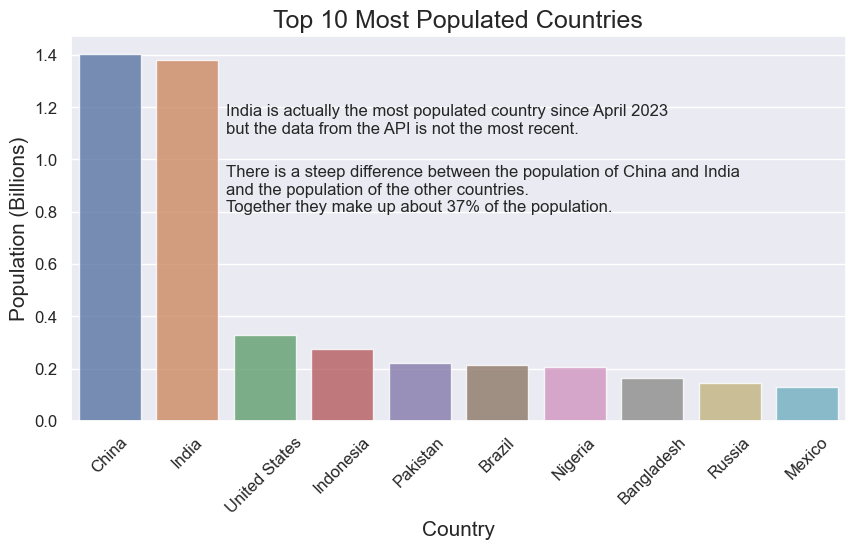

In [212]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_pop_countries,
                 x=top_10_pop_countries.index,
                 y=top_10_pop_countries['population'],
                 hue=top_10_pop_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Most Populated Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# annotate plot
ax.text(1.5, 1100000000, "India is actually the most populated country since April 2023\nbut the data from the API is not the most recent.")
ax.text(1.5, 800000000, "There is a steep difference between the population of China and India\nand the population of the other countries.\nTogether they make up about {} of the population.".format(proportion))

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

#### Q2 - What are the top 3 least populated countries by continent?

In [171]:
countries \
    .sort_values(by=['continent', 'population']) \
    .groupby('continent') \
    .head(3)[['continent', 'name', 'population']] \
    .reset_index(drop=True)

,continent,name,population
0,Africa,Seychelles,98462
1,Africa,São Tomé and Príncipe,219161
2,Africa,Cape Verde,555988
3,Asia,Maldives,540542
4,Asia,Bhutan,771612
5,Asia,Armenia,2963234
6,Europe,Iceland,366425
7,Europe,Malta,525285
8,Europe,Montenegro,621718
9,North America,Saint Lucia,183629


#### Q3 - What is the least populated continent?

In [219]:
total_pop_by_continent = countries.groupby('continent')['population'].sum()
continent = total_pop_by_continent.idxmin()
population = total_pop_by_continent[continent]
print('The least populated continent is', continent, 'with', population, 'people.')

The least populated continent is Oceania with 38381556 people.


#### Q4 - What are the top 20 largest countries?

In [53]:
# Data
top_20_largest_countries = countries \
    .nlargest(n=20, columns='area')[['name', 'area']] \
    .set_index('name')
top_20_largest_countries

,area
name,
Russia,17098242.00
Canada,9984670.00
China,9706961.00
United States,9372610.00
Brazil,8515767.00
Australia,7692024.00
India,3287590.00
Argentina,2780400.00
Kazakhstan,2724900.00


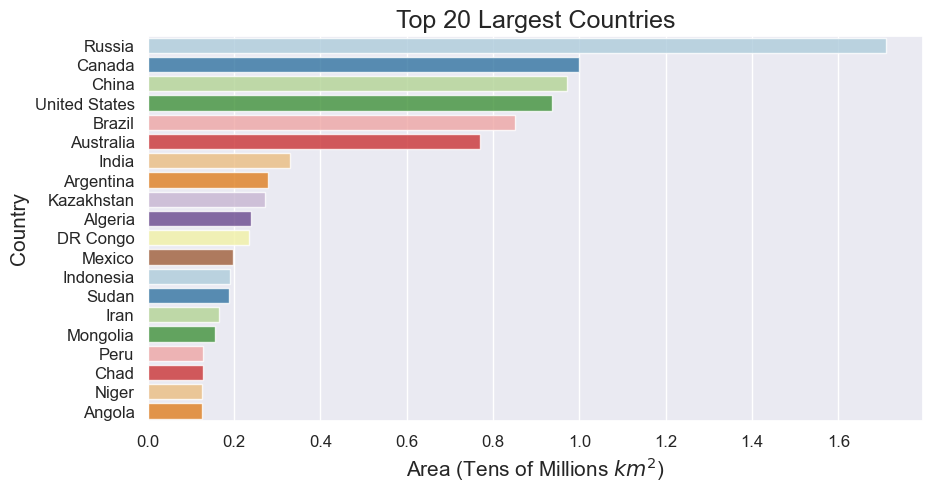

In [54]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_20_largest_countries,
                 x=top_20_largest_countries['area'],
                 y=top_20_largest_countries.index,
                 hue=top_20_largest_countries.index,
                 alpha=0.8,
                 palette='Paired',
                 orient='h')

# labels
ax.set_title('Top 20 Largest Countries', fontsize=18)
ax.set_xlabel('Area (Tens of Millions $km^2$)')
ax.set_ylabel('Country')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

# remove scientific notation showing at the end of the x axis
ax.xaxis.offsetText.set_visible(False)

plt.show()

#### Q5 - What is the smallest continent?

In [56]:
total_area_by_continent = countries.groupby('continent')['area'].sum()
continent = total_area_by_continent.idxmin()
area = round(total_area_by_continent[continent])
print('The smallest continent is', continent, 'which is', area, 'square kilometers.')

The smallest continent is Oceania which is 8234197 square kilometers.


#### Q6 - What are the top 5 most common languages?

In [58]:
# Data
top_languages = countries['languages'].str.split(', ', expand=True).stack().value_counts().nlargest(n=5)
top_languages = pd.DataFrame(top_languages).rename(columns={'count': 'Number of Countries'})
top_languages

,Number of Countries
English,44
French,29
Spanish,18
Arabic,16
Portuguese,8


In [ ]:
# Display English speaking countries

#### Q7A - What are the 10 countries with the most inequalities?

In [60]:
countries.nlargest(n=10, columns='gini')[['name', 'continent', 'gini']]

,name,continent,gini
129,South Africa,Africa,63.00
99,Namibia,Africa,59.10
134,Suriname,South America,57.90
158,Zambia,Africa,57.10
138,São Tomé and Príncipe,Africa,56.30
24,Central African Republic,Africa,56.20
42,Eswatini,Africa,54.60
97,Mozambique,Africa,54.00
17,Brazil,South America,53.40
11,Belize,North America,53.30


#### Q7B - What are the 10 countries with the least inequalities?

In [62]:
countries.nsmallest(n=10, columns='gini')[['name', 'continent', 'gini']]

,name,continent,gini
126,Slovenia,Europe,24.60
33,Czechia,Europe,25.00
125,Slovakia,Europe,25.00
9,Belarus,Europe,25.30
93,Moldova,Europe,25.70
151,United Arab Emirates,Asia,26.00
60,Iceland,Europe,26.10
7,Azerbaijan,Europe,26.60
150,Ukraine,Europe,26.60
10,Belgium,Europe,27.20


What struck me the most is that most of the countries with the least inequalities are from Eastern Europe. Some of them were part of the Soviet Union which has an history of communism.

#### Q8A - What are the 10 countries with the highest death rate?

In [64]:
countries.nlargest(n=10, columns='death_rate')[['name', 'continent', 'death_rate']]

,name,continent,death_rate
150,Ukraine,Europe,18.60
81,Lithuania,Europe,15.20
122,Serbia,Europe,14.90
77,Latvia,Europe,14.70
116,Romania,Europe,14.60
59,Hungary,Europe,14.50
18,Bulgaria,Europe,14.20
93,Moldova,Europe,14.20
117,Russia,Europe,14.00
9,Belarus,Europe,13.30


It's very interesting that all of the 10 countries with the highest mortality rate are from Eastern Europe.

#### Q8B - What are the 10 countries with the lowest death rate?

In [66]:
countries.nsmallest(n=10, columns='death_rate')[['name', 'continent', 'death_rate']]

,name,continent,death_rate
151,United Arab Emirates,Asia,1.70
71,Jordan,Asia,3.50
64,Iraq,Asia,3.90
127,Solomon Islands,Oceania,3.90
137,Syria,Asia,4.00
156,Vanuatu,Oceania,4.00
92,Micronesia,Oceania,4.20
39,Egypt,Africa,4.30
86,Maldives,Asia,4.30
1,Algeria,Africa,4.40


#### Q9A - What is the overall average life expectancy?

In [68]:
avg_life_exp = round(countries['life_expectancy'].mean(), 2)
print('The overall average life expectancy is', avg_life_exp, 'years.')

The overall average life expectancy is 73.11 years.


#### Q9B - What is the average life expectancy by continent?

In [70]:
# Data
countries.groupby('continent')[['life_expectancy']].mean().sort_values(by='life_expectancy')

,life_expectancy
continent,
Africa,65.67
Oceania,71.12
North America,74.81
Asia,74.97
South America,75.77
Europe,79.71


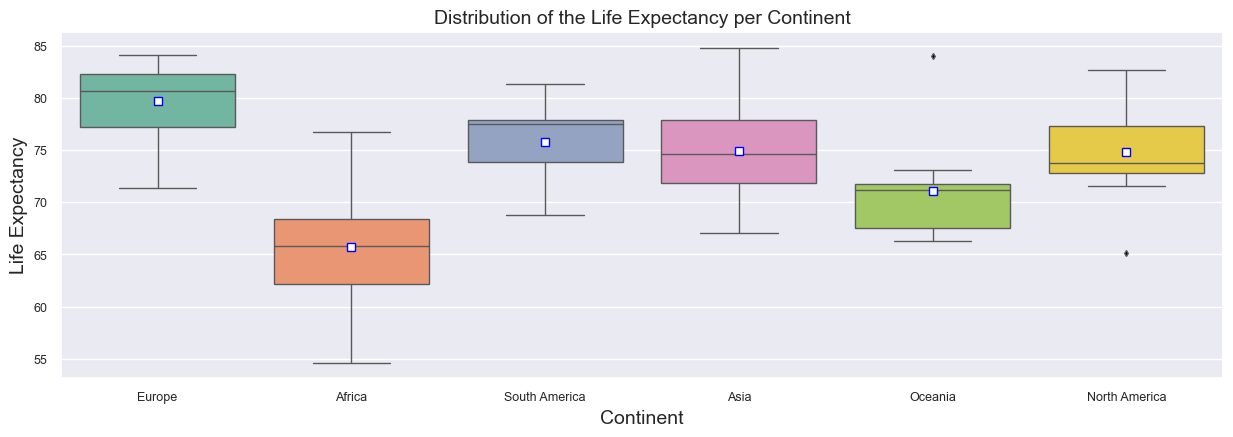

In [71]:
# Visualization

# plot
flierprops = dict(marker='d', markersize=3, markerfacecolor='black')
sns.set(rc={'figure.figsize': (15, 4.5)})
ax = sns.boxplot(data=countries,
                 x='continent',
                 y='life_expectancy',
                 hue='continent',
                 flierprops=flierprops,
                 showmeans=True,
                 palette='Set2',
                 meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})

# labels
ax.set_title('Distribution of the Life Expectancy per Continent', fontsize=14)
ax.set_xlabel('Continent')
ax.set_ylabel('Life Expectancy')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.tick_params(axis='both', labelsize=9)

plt.show()

#### Q10 - What variable seems to be correlated to life expectancy the most?

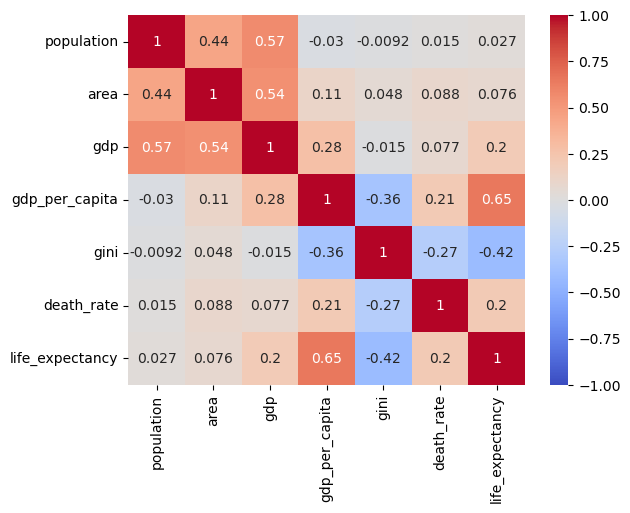

In [73]:
# Display correlation
sns.reset_orig() # prevent plot to be the same size as the previous one
sns.heatmap(corr_table, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

The GINI Index seem to be moderately correlated to the life expectancy (-0.42). The GDP per capita seems to be strongly correlated (0.65).

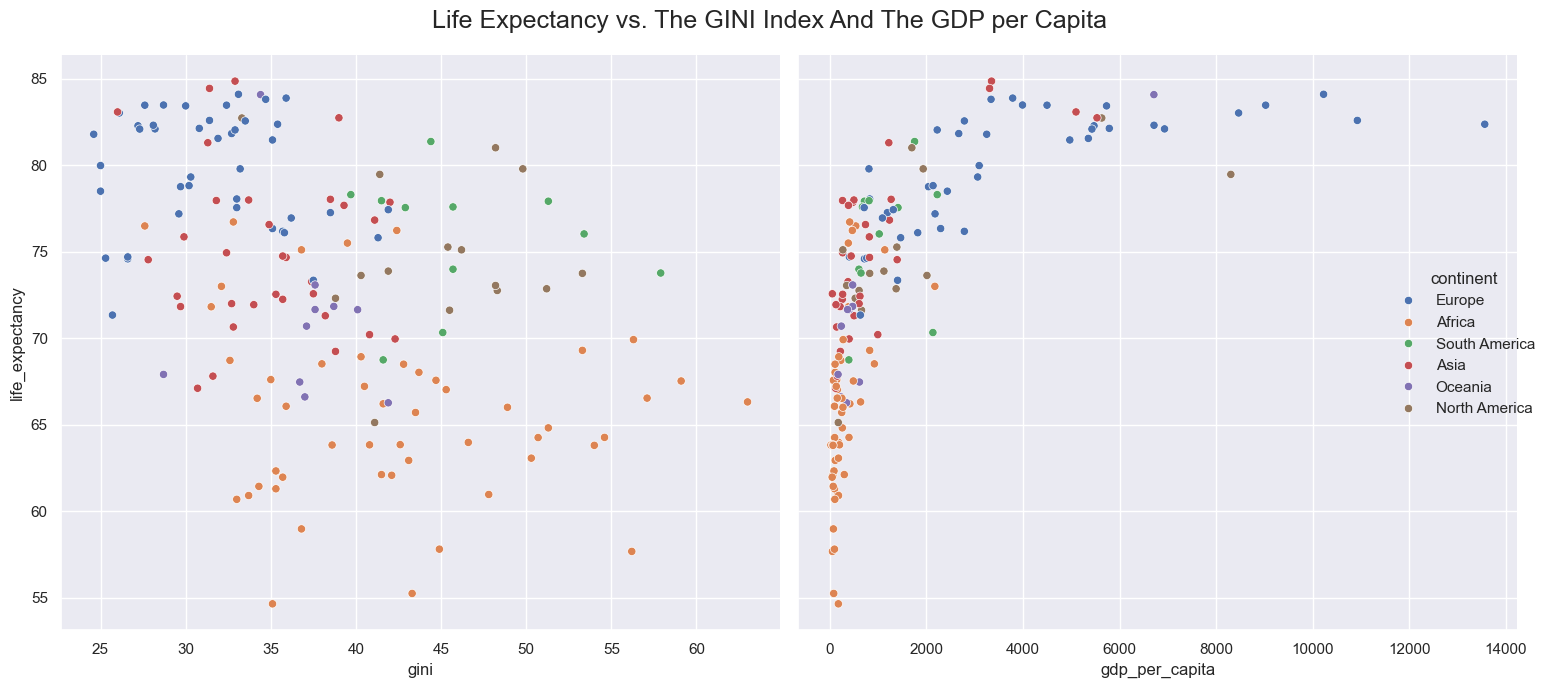

In [240]:
# Display plot of Life Expectancy over the variables

# plot
ax = sns.pairplot(data=countries,
                 x_vars=['gini', 'gdp_per_capita'],
                 y_vars=['life_expectancy'],
                 hue='continent',
                 height=7)
ax.fig.suptitle('Life Expectancy vs. The GINI Index And The GDP per Capita', fontsize=18)

plt.tight_layout()
plt.show()

By looking at the plots, we can say see that the curve with the GINI Index is more linear and the curve with the GDP per capita is more logarithmic. I think both of them are correlated. That would make sense because a country with less inequalities and more wealth usually means a country with a better quality of life, which also leads to a longer life.

## End